In [55]:
import pandas as pd 
import numpy as np 
from datetime import datetime, timedelta
import requests
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import json

In [56]:
datetime.now()

datetime.datetime(2025, 4, 28, 15, 18, 1, 432748)

In [57]:
def fetch_earthquake_data():
    end_date = datetime.now()
    start_date = end_date - timedelta(days=45)

    url = (
        f"https://earthquake.usgs.gov/fdsnws/event/1/query?"
        f"format=geojson&starttime={start_date.strftime('%Y-%m-%d')}"
        f"&endtime={end_date.strftime('%Y-%m-%d')}&minmagnitude=4.0"
    )

    response = requests.get(url)

    return response.json()

eq_data = fetch_earthquake_data()

In [58]:
eq_data['features']


[{'type': 'Feature',
  'properties': {'mag': 4.3,
   'place': '75 km W of Speightstown, Barbados',
   'time': 1745796784655,
   'updated': 1745807879061,
   'tz': None,
   'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000pvgz',
   'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000pvgz&format=geojson',
   'felt': 4,
   'cdi': 3.4,
   'mmi': None,
   'alert': None,
   'status': 'reviewed',
   'tsunami': 0,
   'sig': 286,
   'net': 'us',
   'code': '7000pvgz',
   'ids': ',us7000pvgz,',
   'sources': ',us,',
   'types': ',dyfi,moment-tensor,origin,phase-data,',
   'nst': 54,
   'dmin': 0.761,
   'rms': 0.48,
   'gap': 88,
   'magType': 'mwr',
   'type': 'earthquake',
   'title': 'M 4.3 - 75 km W of Speightstown, Barbados'},
  'geometry': {'type': 'Point', 'coordinates': [-60.3358, 13.2249, 36.538]},
  'id': 'us7000pvgz'},
 {'type': 'Feature',
  'properties': {'mag': 4.5,
   'place': '55 km SSW of Modisi, Indonesia',
   'time': 1745792024326,
   'updat

In [59]:
earthquake_list = []
for feature in eq_data["features"]:
    lon, lat, depth = feature['geometry']['coordinates']
    properties = feature["properties"]
    time = datetime.fromtimestamp(feature['properties']['time'] / 1000)
    
    earthquake_list.append({
        "longitude": lon,
        "latitude": lat,
        "depth": depth,
        "time": time,
        "sig": properties.get("sig", None),
        "tsunami": properties.get("tsunami", None),
        "gap": properties.get("gap", None),
        "dmin": properties.get("dmin", None),
        "rms": properties.get("rms", None),
        "nst": properties.get("nst", None),
        "magType": properties.get("magType", None),
        "magnitude": properties["mag"],
        "location": properties['place'],
        'geometry': Point(lon, lat)
    })

# Convert to DataFrame
df = pd.DataFrame(earthquake_list)

df.head()

,longitude,latitude,depth,time,sig,tsunami,gap,dmin,rms,nst,magType,magnitude,location,geometry
0,-60.3358,13.2249,36.538,2025-04-28 05:33:04.655,286,0,88.0,0.761,0.48,54.0,mwr,4.3,"75 km W of Speightstown, Barbados",POINT (-60.3358 13.2249)
1,124.3160,-0.0388,86.009,2025-04-28 04:13:44.326,312,0,69.0,1.563,0.84,52.0,mb,4.5,"55 km SSW of Modisi, Indonesia",POINT (124.316 -0.0388)
2,-179.8824,-23.5493,536.403,2025-04-28 04:13:41.759,326,0,105.0,5.936,0.66,65.0,mb,4.6,south of the Fiji Islands,POINT (-179.8824 -23.5493)
3,-168.5834,52.4198,35.000,2025-04-28 02:09:40.116,340,0,145.0,0.577,0.55,62.0,mb,4.7,"60 km SSE of Nikolski, Alaska",POINT (-168.5834 52.4198)
4,-168.6436,52.4473,35.000,2025-04-28 02:07:05.759,326,0,136.0,0.541,0.55,81.0,mb,4.6,"56 km SSE of Nikolski, Alaska",POINT (-168.6436 52.4473)


In [60]:
gdf = gpd.GeoDataFrame(df, geometry='geometry')

m = folium.Map(location=[0,0], zoom_start=2)


for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius= row['magnitude'] * 2,
        popup=f"Magnitude: {row['magnitude']}<br>Location: {row['location']}<br>Depth: {row['depth']} km",
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

heat_data =  [[row['latitude'], row['longitude'], row['magnitude']] for idx, row in gdf.iterrows()]
HeatMap(heat_data).add_to(m)
m

In [61]:
m.save("earthquake_map.html")

In [62]:
df.dropna(inplace=True)

In [63]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

df['magType'] = encoder.fit_transform(df['magType'])

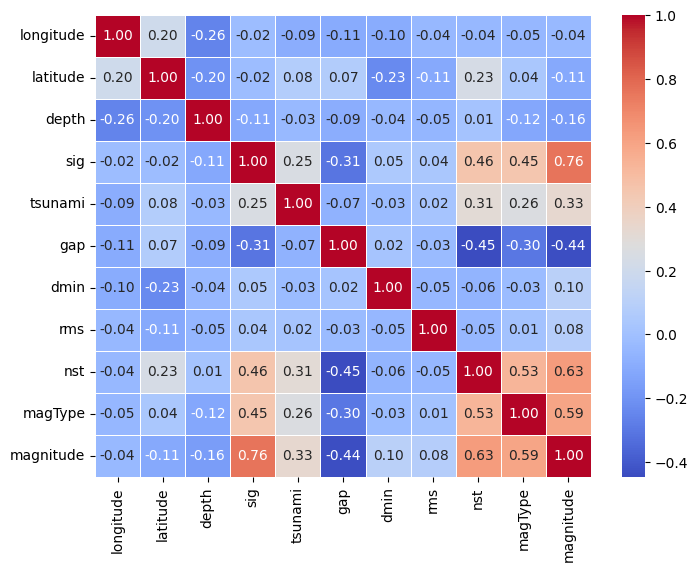

In [64]:
plt.figure(figsize=(8,6))
sns.heatmap(df.drop(columns=['location', 'time', 'geometry']).corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

In [65]:
df_cor = df.drop(columns=['location', 'time', 'geometry']).corr()
df_cor['magnitude']

longitude   -0.035049
latitude    -0.108127
depth       -0.162187
sig          0.762234
tsunami      0.331201
gap         -0.435655
dmin         0.103022
rms          0.079457
nst          0.627156
magType      0.594116
magnitude    1.000000
Name: magnitude, dtype: float64

In [66]:
X = df[['longitude', 'latitude', 'depth', 'gap', 'dmin', 'rms',
       'magType', "tsunami", 'nst', 'sig']]
y = df['magnitude']

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,longitude,latitude,depth,gap,dmin,rms,magType,tsunami,nst,sig
259,147.6504,43.5194,39.631,131.0,3.634,0.59,0,0,66.0,298
1075,-73.0438,6.7029,163.334,39.0,0.806,0.73,0,0,42.0,298
644,151.5222,-6.4474,10.000,16.0,2.330,0.64,0,0,152.0,416
806,26.3186,-52.4604,10.000,72.0,17.618,0.42,0,0,34.0,340
386,151.8901,-6.2096,10.000,118.0,1.895,0.79,0,0,18.0,284
...,...,...,...,...,...,...,...,...,...,...
1104,-13.2754,-46.7223,10.000,94.0,34.410,0.43,0,0,32.0,326
1139,166.9915,-14.0776,119.662,64.0,1.377,0.92,5,0,70.0,432
1303,-75.0880,-8.4830,126.589,118.0,2.475,0.86,0,0,33.0,259
867,-130.5546,-54.6460,10.000,103.0,35.528,0.65,0,0,18.0,312


In [68]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train,y_train)


LinearRegression()

In [69]:
y_pred_lr = lr.predict(X_test)

In [70]:
comparison_lr = pd.DataFrame({
    "Actual Data": y_test,
    "Predicted Data": y_pred_lr
})
comparison_lr

,Actual Data,Predicted Data
900,5.1,4.784089
1114,4.3,4.430363
419,4.5,4.504524
528,4.3,4.393470
1045,4.4,4.603542
...,...,...
485,4.3,4.486801
1371,4.3,4.399353
809,4.2,4.391245
657,4.4,4.436882


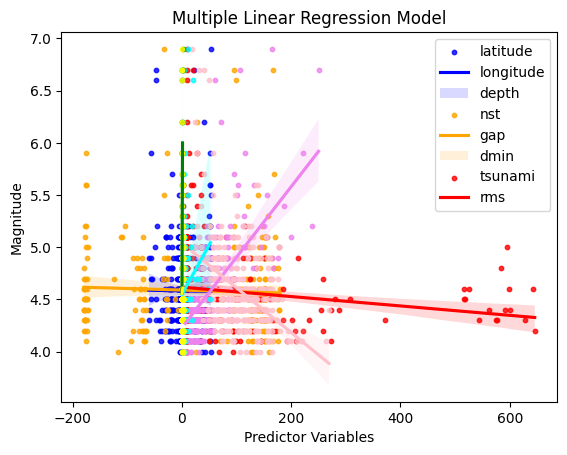

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the regression line
sns.regplot(x=X_test['latitude'], y=y_test, color='blue', scatter_kws={'s': 10})
sns.regplot(x=X_test['longitude'], y=y_test, color='orange', scatter_kws={'s': 10})
sns.regplot(x=X_test['depth'], y=y_test, color='red', scatter_kws={'s': 10})
sns.regplot(x=X_test['nst'], y=y_test, color='violet', scatter_kws={'s': 10})
sns.regplot(x=X_test['gap'], y=y_test, color='pink', scatter_kws={'s': 10})
sns.regplot(x=X_test['dmin'], y=y_test, color='cyan', scatter_kws={'s': 10})
sns.regplot(x=X_test['tsunami'], y=y_test, color='green', scatter_kws={'s': 10})
sns.regplot(x=X_test['rms'], y=y_test, color='yellow', scatter_kws={'s': 10})


plt.legend(labels=['latitude', 'longitude', 'depth', 'nst', 'gap', 'dmin', "tsunami", 'rms'])
plt.xlabel('Predictor Variables')
plt.ylabel('Magnitude')
plt.title('Multiple Linear Regression Model')
plt.show()

In [71]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, random_state=42)

reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [72]:
y_pred_reg = reg.predict(X_test)

In [73]:
comparison_rf = pd.DataFrame({
    "Actual Data": y_test,
    "Predicted Data": y_pred_reg
})
comparison_rf

,Actual Data,Predicted Data
900,5.1,5.041
1114,4.3,4.300
419,4.5,4.500
528,4.3,4.300
1045,4.4,4.400
...,...,...
485,4.3,4.300
1371,4.3,4.300
809,4.2,4.200
657,4.4,4.400


In [74]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def metrics(y_test, y_pred):    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, y_pred)

    return mae, mse, rmse, r2

model_predictions = {
    "Linear Regression": y_pred_lr,
    "Random Forest": y_pred_reg
}

results = []

for model_name, y_pred in model_predictions.items():
    mae, mse, rmse, r2 = metrics(y_test, y_pred)
    results.append([model_name, mae, mse, rmse, r2])

df_scores = pd.DataFrame(results, columns=["Model Name", "MAE", "MSE", "RMSE", "R2 Score"])

In [75]:
df_scores

,Model Name,MAE,MSE,RMSE,R2 Score
0,Linear Regression,0.152571,0.051283,0.226456,0.734844
1,Random Forest,0.007049,0.002385,0.048836,0.987669


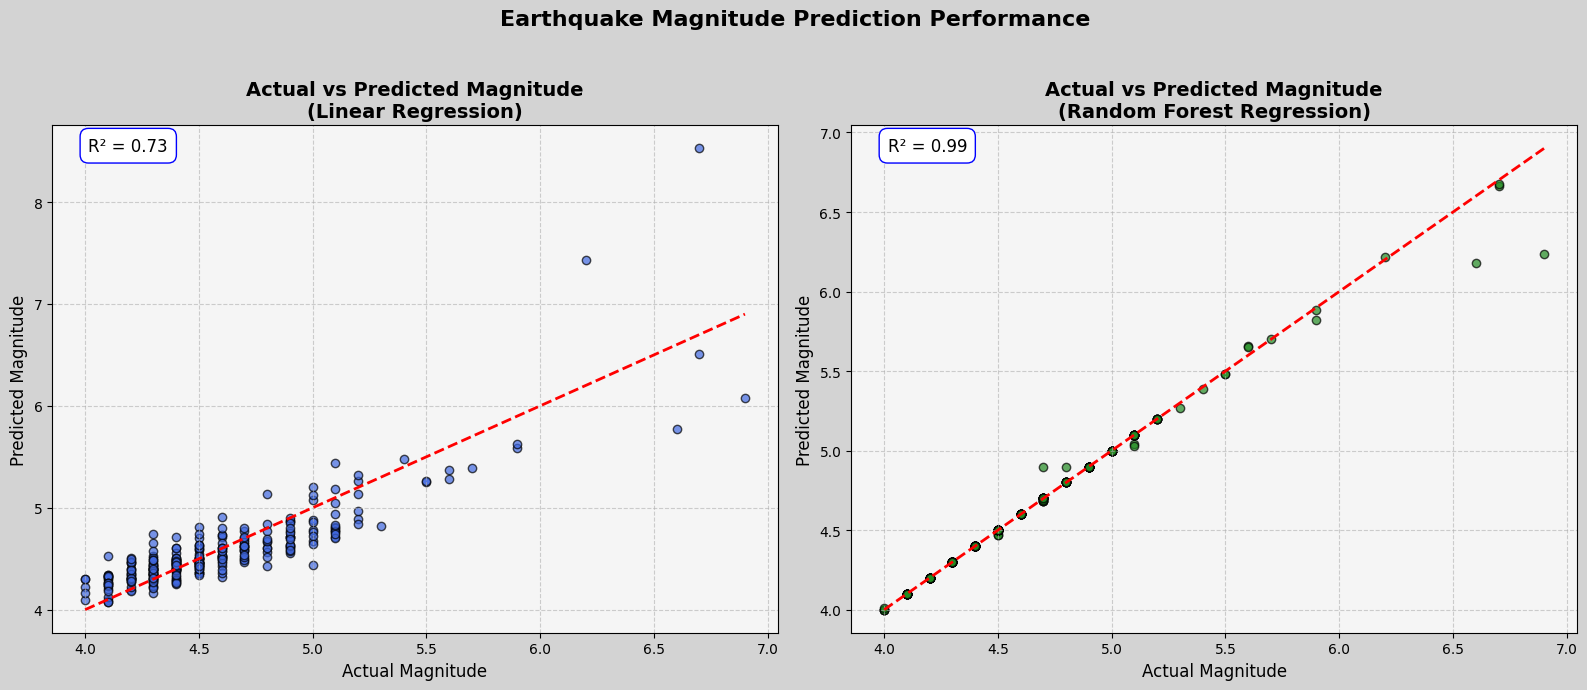

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


fig.patch.set_facecolor('lightgray')  


ax1.set_facecolor('whitesmoke')  
ax2.set_facecolor('whitesmoke')  


ax1.scatter(y_test, y_pred_lr, color='royalblue', edgecolor='black', alpha=0.7)
ax2.scatter(y_test, y_pred_reg, color='forestgreen', edgecolor='black', alpha=0.7)


for ax in [ax1, ax2]:
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
    ax.grid(True, linestyle='--', alpha=0.6)


ax1.set_title('Actual vs Predicted Magnitude\n(Linear Regression)', fontsize=14, fontweight='bold')
ax2.set_title('Actual vs Predicted Magnitude\n(Random Forest Regression)', fontsize=14, fontweight='bold')

ax1.set_xlabel('Actual Magnitude', fontsize=12)
ax1.set_ylabel('Predicted Magnitude', fontsize=12)
ax2.set_xlabel('Actual Magnitude', fontsize=12)
ax2.set_ylabel('Predicted Magnitude', fontsize=12)


ax1.text(0.05, 0.95, f'R² = {r2_score(y_test, y_pred_lr):.2f}', transform=ax1.transAxes,
         fontsize=12, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))
ax2.text(0.05, 0.95, f'R² = {r2_score(y_test, y_pred_reg):.2f}', transform=ax2.transAxes,
         fontsize=12, bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.5'))


plt.suptitle('Earthquake Magnitude Prediction Performance', fontsize=16, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()
